# Tensorflow: Word Embeddings
* Reference: https://www.tensorflow.org/text/guide/word_embeddings

## Setup

In [1]:
import io, os, re, shutil
import string
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

## Download the IMDB Dataset

In [2]:
IMDB_MOVIE_REVIEW_DATA_URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file(
    "aclImdb_v1.tar.gz", IMDB_MOVIE_REVIEW_DATA_URL,
    untar=True, cache_dir='.', cache_subdir='')

84140032/84125825 [==============================] - 8s 0us/step


In [3]:
dataset_dir = os.path.join( os.path.dirname(dataset), 'aclImdb' )
# os.listdir(dataset_dir)

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
# os.listdir(train_dir)

In [5]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [6]:
batch_size = 1024
seed = 123
train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [7]:
# for text_batch, label_batch in train_ds.take(1):
#     for i in range(5):
#         print( label_batch[i].numpy(), text_batch.numpy()[i].decode('ascii') )

## Configure the Dataset for Performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Using the Embedding Layer

In [9]:
# Embed a 1000-word vocabulary into 5 dimensions
embedding_layer = tf.keras.layers.Embedding( 1000, 8 )

In [10]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()


array([[-0.03287995,  0.02945367,  0.01589883,  0.02752216,  0.00812225,
         0.04390066, -0.04882411,  0.00359597],
       [ 0.03056015,  0.04533662,  0.04216014, -0.04893019, -0.04581586,
         0.00010297,  0.03317013, -0.00468122],
       [ 0.04515883, -0.01694564, -0.02838172, -0.03202998, -0.00071923,
        -0.02593068,  0.01548853,  0.03944108]], dtype=float32)

In [11]:
result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]]))
result.shape

TensorShape([2, 3, 8])

## Text Preprocessing

In [12]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  stripped_punct = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')
  return stripped_punct

In [13]:
# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

In [14]:

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [15]:

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)


In [16]:
# Example: Determine the vector of integers associated with a sample string
vectorize_layer( tf.constant(['This is a test'] ))

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[  11,    7,    4, 2054,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int64)>

In [17]:
# Example: Convert a vector of integers to the associated text string
abc = vectorize_layer.get_vocabulary()
" ".join( [ abc[i] for i in [  11,    7,    4, 2054, 0, 0 ] if i > 0 ] )

'this is a test'

In [18]:
abc = [ x for x in train_ds ][18]
# print( [ f"{'Positive' if abc[1][i] else 'Negative'} => {(abc[0][i])}" for i in range( len(abc[0] )) ] )
print( [ f"{'Positive' if abc[1][i] else 'Negative'} => {(abc[0][i])}" for i in range( 1 ) ] )

['Negative => b\'I can\\\'t for the life of me remember why--I must have had a free ticket or something--but I saw this movie in the theater when it was released. I don\\\'t remember who I went with, which theater I was in, or even which city. All I remember was how offended I was at this travesty someone dared to call a film, and how half the people in the theater walked out before the movie was over. Unfortunately I stuck it out to end, which I still consider to be one of the worst mistakes of my life thus far. My offense became pure horror when just before the closing credits the smarmy demon child sticks his head out from behind a sign and says "Look for Problem Child 2, coming soon!" That was hands-down THE most terrifying moment ever recorded on film.<br /><br />The plot, if I recall correctly, involved John Ritter and perhaps his wife (Lord, how I\\\'ve tried without success to block this film out of my mind) adopting a "problem child." Maybe they think they can reform him, or s

## Create a Classification Model

In [19]:
embedding_dim = 16
model = Sequential( [
    vectorize_layer,
    Embedding( vocab_size, embedding_dim, name='embedding'),
    GlobalAveragePooling1D(),
#     Dense(16, activation='relu'),
    Dense(1)
    ])

## Compile and Train the Model

In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

In [22]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[tensorboard_callback]
)

Epoch 1/15
20/20 [==============================] - 9s 419ms/step - loss: 0.6916 - accuracy: 0.5028 - val_loss: 0.6898 - val_accuracy: 0.4886
Epoch 2/15
20/20 [==============================] - 4s 180ms/step - loss: 0.6879 - accuracy: 0.5028 - val_loss: 0.6859 - val_accuracy: 0.4886
Epoch 3/15
20/20 [==============================] - 4s 178ms/step - loss: 0.6836 - accuracy: 0.5028 - val_loss: 0.6814 - val_accuracy: 0.4886
Epoch 4/15
20/20 [==============================] - 4s 184ms/step - loss: 0.6785 - accuracy: 0.5028 - val_loss: 0.6761 - val_accuracy: 0.4886
Epoch 5/15
20/20 [==============================] - 4s 183ms/step - loss: 0.6726 - accuracy: 0.5028 - val_loss: 0.6702 - val_accuracy: 0.4886
Epoch 6/15
20/20 [==============================] - 4s 177ms/step - loss: 0.6661 - accuracy: 0.5028 - val_loss: 0.6636 - val_accuracy: 0.4886
Epoch 7/15
20/20 [==============================] - 3s 176ms/step - loss: 0.6588 - accuracy: 0.5031 - val_loss: 0.6566 - val_accuracy: 0.4886
Epoch 

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
_________________________________________________________________


In [31]:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 23932), started 1:13:49 ago. (Use '!kill 23932' to kill it.)

In [25]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

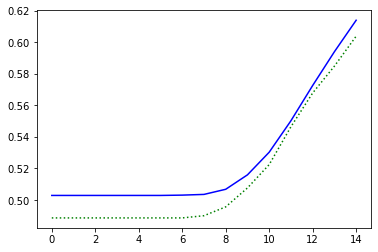

In [26]:
plt.plot( 'accuracy', 'b-', data=model.history.history )
plt.plot( 'val_accuracy', 'g:', data=model.history.history )

## Retrieve the Trained Word Embeddings and Save them to Disk

In [27]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [28]:
with io.open('./data/vectors.tsv', 'w', encoding='utf-8') as out_v:
    with io.open('./data/metadata.tsv', 'w', encoding='utf-8') as out_m:
        for index, word in enumerate(vocab):
            if index == 0:
                continue    # skip 0, it's padding
                
            vec = weights[index]
            out_v.write( '\t'.join( [ str(x) for x in vec ]) + '\n' )
            out_m.write( word + '\n' )


## Visualize the Embeddings
* Tensorflow Embedding Projector: http://projector.tensorflow.org/
* Click on "Load data".
* Upload the two files you created above: vecs.tsv and meta.tsv.